In [41]:
!pip install keras 
!pip install pydot
!pip install pydot-ng
!pip install graphviz
!pip install pydotplus
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import pandas as pd
import seaborn as sns
import sys
sys.path.append("/opt/conda/lib/python3.7/site-packages")
#sys.path.append("./har-dataset/src")
from hards.functional.io import read_ready_to_load_set
import warnings
warnings.filterwarnings('ignore')

In [65]:
dataset_path = os.path.join("../data/", "DSADS", "HAND-ANKLE_WS30_SS15_30Hz", "ReadyMade", "DEFAULT/")
train_data_X = np.load(dataset_path+ "TRAIN/" + "data.npy" )
valid_data_X = np.load(dataset_path+ "VAL/" + "data.npy" )
trainX = np.concatenate((train_data_X, valid_data_X))
trainX = trainX.reshape(68400, 30, 6)
train_data_Y = np.load(dataset_path+ "TRAIN/" + "targets/" + "full.npy" )
valid_data_Y = np.load(dataset_path+ "VAL/" + "targets/" + "full.npy" )
trainY = np.concatenate((train_data_Y, valid_data_Y))
trainY = np.array([i[0] for i in trainY])

test_data_X = np.load(dataset_path+ "TEST/" + "data.npy" )
testX = test_data_X.reshape(22800, 30, 6)
test_data_Y = np.load(dataset_path+ "TEST/" + "targets/" + "full.npy" )
testY = np.array([i[0] for i in test_data_Y])

testTimes = []

In [66]:
def generate_feature_names():
    '''Creates feature names for dataframe header'''
    feat_names = []
    for unit_label in ["RA", "LL"]:
        for position in ['X','Y','Z']:
            feat_names.append(unit_label + "_" + position + "acc")
    return feat_names

feat_names = generate_feature_names()

#行動の定義
"""activities = {1:"sitting", 2:"standing", 3:"lying on back", 4:"lying on right side", 5:"ascending stairs", 
              6:"descending stairs", 7:"standing in an elevator still", 8:"moving around in an elevator", 
              9:"walking in a parking lot", 10:"walking on a treadmill with a speed of 4 km/h in flat", 
              11:"walking on a treadmill with a speed of 4 km/h in 15 deg inclined positions", 
              12:"running on a treadmill with a speed of 8 km/h", 13:"exercising on a stepper", 
              14:"exercising on a cross trainer", 15:"cycling on an exercise bike in horizontal positions ", 
              16:"cycling on an exercise bike in vertical positions", 17:"rowing", 18:"jumping", 19:"playing basketball"}
"""

def generate_act_dictionary():
    activities = dict.fromkeys(range(1, 20), '')
    for key in activities:
        activities[key] = 'A'+ str(key)
        
    return activities
    
activities = generate_act_dictionary()

{1: 'A1', 2: 'A2', 3: 'A3', 4: 'A4', 5: 'A5', 6: 'A6', 7: 'A7', 8: 'A8', 9: 'A9', 10: 'A10', 11: 'A11', 12: 'A12', 13: 'A13', 14: 'A14', 15: 'A15', 16: 'A16', 17: 'A17', 18: 'A18', 19: 'A19'}


In [67]:
def timeseries_standardize(trainX, testX):
    '''
    時系列データを次元ごとに標準化
    
    Parameters
    ----------
    trainX : numpy.ndarray
        学習データ。(ウインドウ数, ウインドウ幅, 次元数)のshape
    testX : numpy.ndarray
        テストデータ。(ウインドウ数, ウインドウ幅, 次元数)のshape
        
    Returns
    -------
    trainX :numpy.ndarray
        標準化された学習データ
    testX :numpy.ndarray
        標準化されたテストデータ
    '''
    ss = preprocessing.StandardScaler()#標準化のためのモジュール
    trainXshape = trainX.shape #元のshapeを保持
    trainX = trainX.reshape(-1, trainX.shape[2]) #2次元のndarrayに変換。(-1,次元数)のshape
    ss.fit(trainX)#学習データから、各次元ごとの平均と分散を計算
    trainX = ss.transform(trainX) #標準化
    trainX = trainX.reshape(trainXshape) #元のshapeに戻す

    testXshape = testX.shape#元のshapeを保持
    testX = testX.reshape(-1, testX.shape[2]) #2次元のndarrayに変換。(-1,次元数)のshape
    testX = ss.transform(testX) #標準化
    testX = testX.reshape(testXshape) #元のshapeに戻す
    return trainX, testX

In [68]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    Confusion matrixを描く
    
    Parameters
    ----------
    cm : np.ndarray
        confusion matrix. sklearn.metrics.confusion_matrixで作成
    classes : list
        クラスのリスト
    normalize : Boolean
        ノーマライズしたConfusion matrixにするかどうか 
    title : String
        図のタイトル
    cmap : cm.colormap
        色を塗るのに使うカラーマップ
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [69]:
#standardize
trainX, testX = timeseries_standardize(trainX, testX)
print("trainX.shape (ウインドウ数, ウインドウ幅, 次元数): ",trainX.shape)
print("len(trainY): ",len(trainY))
print("testX.shape (ウインドウ数, ウインドウ幅, 次元数): ",testX.shape)

trainX.shape (ウインドウ数, ウインドウ幅, 次元数):  (68400, 30, 6)
len(trainY):  68400
testX.shape (ウインドウ数, ウインドウ幅, 次元数):  (22800, 30, 6)


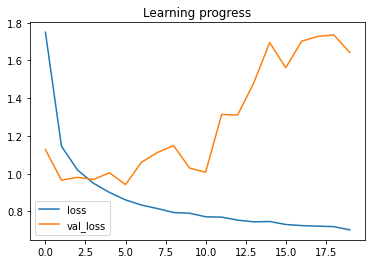

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_37 (Conv1D)           (None, 30, 8)             200       
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 15, 8)             0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 15, 8)             264       
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 7, 8)              0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 7, 8)              264       
_________________________________________________________________
flatten_13 (Flatten)         (None, 56)                0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 56)              

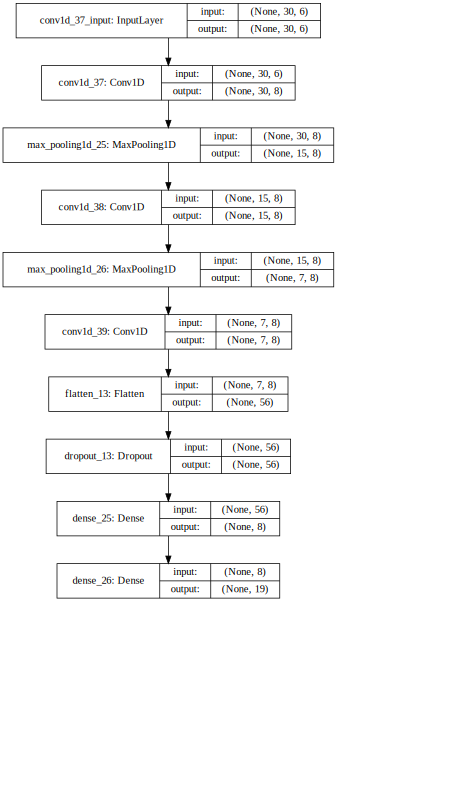

              precision    recall  f1-score   support

          A1       0.99      0.39      0.56      1200
          A2       0.00      0.00      0.00      1200
          A3       1.00      0.50      0.66      1200
          A4       0.62      1.00      0.77      1200
          A5       0.73      0.51      0.60      1200
          A6       0.59      0.73      0.65      1200
          A7       0.39      0.51      0.44      1200
          A8       0.32      0.50      0.39      1200
          A9       0.07      0.07      0.07      1200
         A10       0.33      0.50      0.39      1200
         A11       0.59      0.17      0.26      1200
         A12       0.88      1.00      0.93      1200
         A13       0.82      0.69      0.75      1200
         A14       0.71      0.81      0.76      1200
         A15       0.99      0.96      0.98      1200
         A16       0.97      0.87      0.92      1200
         A17       0.65      0.98      0.78      1200
         A18       0.86    

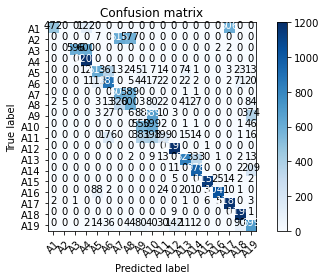

In [71]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import keras
from keras.layers import Dense, LSTM, Bidirectional, TimeDistributed, Dropout, normalization
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential
from keras.utils import np_utils
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping
from IPython.display import SVG
import keras_utils

def get_activity_index(act_dict):
    '''
    activity labelとindexの2つのリスト作成
    
    Parameters
    ----------
    act_dict : dictionary
        行動のリスト。settingsの中のactivities

    Returns
    -------
    labels : list
        行動のラベルのリスト
    indices : list
        行動のラベルの番号のリスト
    '''
    labels = []
    indices = []
    for k,v in act_dict.items():
        indices.append(k)
        labels.append(v)

    return labels, indices

def build_model(input_dim,timesteps,class_num):
    '''
    CNNを構築。各windowごとに推定
    Parameters
    ----------
    input_dim : Integer
        入力時系列の次元数
    timesteps : Integer
        入力時系列の系列長
    class_num : Integer
        分類クラス数
        
    Returns
    -------
    model :Sequential
        学習前ニューラルネットワーク
    '''
    hidden_unit = 8 #各層のノード数
    kernel_size = 4 #カーネルサイズ
    
    model = Sequential()
    #1層目。時刻方向に1D畳み込み。input_shape: 系列長と次元数を指定。
    model.add(Conv1D(hidden_unit, kernel_size, padding='same', input_shape=(timesteps, input_dim), activation='relu'))
    model.add(MaxPooling1D())#Max pooling
    model.add(Conv1D(hidden_unit, kernel_size, padding='same', activation='relu'))
    model.add(MaxPooling1D())
    model.add(Conv1D(hidden_unit, kernel_size, padding='same', activation='relu'))
    model.add(Flatten())#一次元に平滑化
    model.add(Dropout(0.5))#dropout. overfitを防ぐ
    model.add(Dense(hidden_unit, activation='relu'))
    model.add(Dense(class_num, activation='softmax'))#出力層。クラス数を指定。
    optimizer = keras.optimizers.Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)#モデルのコンパイル
    return model

def ApplyConvNetwork(trainX, trainY, testX, testY, testTimes, features):
    '''
    ニューラルネットワークによる分類
    
    Parameters
    ----------
    trainX : numpy.ndarray
        学習データ
    trainY : numpy.ndarray
        学習データラベル
    testX : numpy.ndarray
        テストデータ
    testY : numpy.ndarray
        テストデータラベル
    testTimes : list
        テストデータのタイムスタンプ
    features : list
        入力系列の各次元の名前
        
    Returns
    -------
    predict_vec : list
        分類確率のリスト
    lb.classes_ : list
        LabelBinarizerのクラスの番号のリスト
    '''
    target_names,indices = get_activity_index(activities)
    #Yをone-hot encodingに変換
    lb = LabelBinarizer()
    lb.fit(indices)
    trainY_b = lb.transform(trainY)
    testY_b = lb.transform(testY)
    #モデルを構築
    model = build_model(trainX.shape[2], trainX.shape[1], len(target_names))
    #学習・推定
    nb_epoch = 20 #エポック数
    plot_losses = keras_utils.PlotLosses() #lossの可視化
    model.fit(trainX, trainY_b, nb_epoch=nb_epoch, validation_split=0.2, callbacks=[plot_losses], verbose=0)#学習
    model.summary()#モデル概要
    img = SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))#モデルの可視化
    display(img)
    predict_vec = model.predict(testX)#推定
    predict_class = np.argmax(predict_vec, axis=1)#推定結果をクラスのインデックスの表現（0,1,2,...,len(class_num)）になおす
    predict = [lb.classes_[x] for x in predict_class] #元のラベル（数値）に戻す
    
    #分類結果
    result = classification_report(testY, predict, target_names=target_names)
    print(result)
    
    #Confusion matrix
    cnf_matrix = confusion_matrix(testY, predict)
    plot_confusion_matrix(cnf_matrix, classes=target_names)

    return predict_vec, lb.classes_
    
predict_vec, classes_ = ApplyConvNetwork(trainX, trainY, testX, testY, testTimes, feat_names)#最後の引数は特徴名のリスト。最初（time）と最後（label）以外
    

In [12]:
#分類の信頼度表示
confidences = np.max(predict_vec, axis=1) #最大の分類確率をスコアにする
predict = [classes_[x] for x in np.argmax(predict_vec, axis=1)]#分類クラスのインデックスのリスト
test_data_with_conf_pred = pd.merge(test_data, pd.DataFrame(data = {'time':testTimes, 'predicted_label':predict,'confidence':confidences}), on='time')#加速度のDataFrameに分類結果を連結
viz_utils_opportunity.plot_data_segnemt_interactive(test_data_with_conf_pred, settings.activities, "label")#インタラクティブに表示

NameError: name 'test_data' is not defined